In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import re
from IPython.display import clear_output
import requests
import json
import math
import fiona

In [13]:
project_path = os.path.abspath(os.path.join("readfiles.ipynb", os.pardir, os.pardir))
print("Found project in: ", project_path)
data_path = os.path.join(project_path, "Data")

external_data_path = "/media/seppe/DiskSpaceInvader/3DHouseData"

lookup_panda = pd.read_csv(os.path.join(project_path, "overviewdataframe.csv"))
lookup_panda.info()

Found project in:  /home/seppe/Projects/BeCode/3D-House-Project
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88064 entries, 0 to 88063
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_path     88064 non-null  object 
 1   id            88064 non-null  object 
 2   left_bound    88064 non-null  float64
 3   bottom_bound  88064 non-null  float64
 4   right_bound   88064 non-null  float64
 5   top_bound     88064 non-null  float64
 6   width_bound   88064 non-null  int64  
 7   height_bound  88064 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.4+ MB


In [104]:
def address_lookup(addr:str, debug=False):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={addr}&c=1",)
    ret_dict = {}
    for k,v in req.json()["LocationResult"][0].items():
        if debug: print(f"{k}: {v}")
        ret_dict[k] = [v]
    return ret_dict

beacon = address_lookup("Hooiendonkstraat 49, 2801 Heffen", True)
beacon.keys()

Municipality: Mechelen
Zipcode: 2801
Thoroughfarename: Hooiendonkstraat
Housenumber: 49
ID: 2273692
FormattedAddress: Hooiendonkstraat 49, 2801 Mechelen
Location: {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}
LocationType: crab_huisnummer_afgeleidVanGebouw
BoundingBox: {'LowerLeft': {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}, 'UpperRight': {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}}


dict_keys(['Municipality', 'Zipcode', 'Thoroughfarename', 'Housenumber', 'ID', 'FormattedAddress', 'Location', 'LocationType', 'BoundingBox'])

In [105]:
margin = 10

def find_tiles(tile_panda, address_dict, debug=False):
    results = []
    bbox = address_dict['BoundingBox'][0]
    lower_left, upper_right = bbox['LowerLeft'], bbox['UpperRight']
    left, bottom = math.floor(lower_left['X_Lambert72']), math.floor(lower_left['Y_Lambert72'])
    right, top = math.ceil(upper_right['X_Lambert72']), math.ceil(upper_right['Y_Lambert72'])
    left -= margin
    bottom -= margin
    right += margin
    top += margin
    if debug: print(bbox, left, bottom, right, top)
    for row in tile_panda.itertuples():
        if row.left_bound < left < row.right_bound and row.bottom_bound < bottom < row.top_bound:
            if debug: print(f"Found LowerLeft {lower_left}")
            if row.file_path not in results:
                results.append(row.file_path)
        if row.left_bound < right < row.right_bound and row.bottom_bound < top < row.top_bound:
            if debug: print(f"Found UpperRight {upper_right}")
            if row.file_path not in results:
                results.append(row.file_path)
    return (results, (left, bottom, right, top))
        
        
        
beacontifs = find_tiles(lookup_panda, beacon, True)

{'LowerLeft': {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}, 'UpperRight': {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}} 153608 193535 153629 193556
Found LowerLeft {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}
Found UpperRight {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}
Found LowerLeft {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}
Found UpperRight {'Lat_WGS84': 51.05206034510974, 'Lon_WGS84': 4.420362429143242, 'X_Lambert72': 153618.6, 'Y_Lambert72': 193545.99}


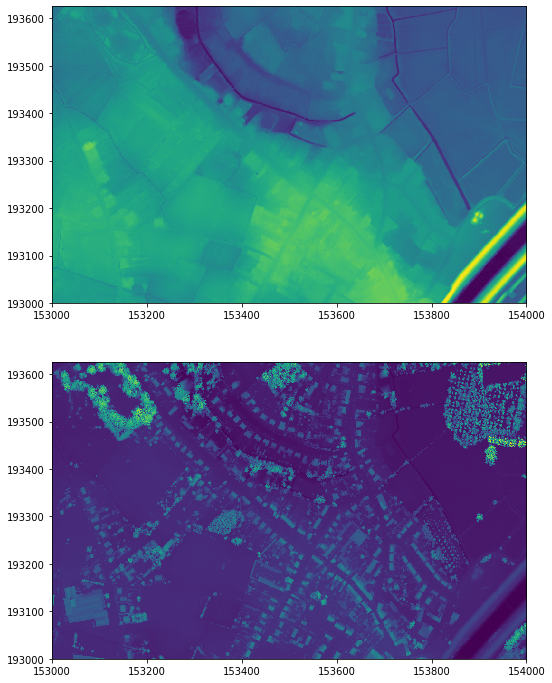

(['/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDTMRAS1m_k23/GeoTIFF/DHMVIIDTMRAS1m_k23_1_0_3_3_3.tif', '/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k23/GeoTIFF/DHMVIIDSMRAS1m_k23_1_0_3_3_3.tif'], (153608, 193535, 153629, 193556))


In [106]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
dtm_tif = beacontifs[0][0]
dtm_im = rio.open(dtm_tif)
show(dtm_im, ax=ax1, )

dsm_tif = beacontifs[0][1]
dsm_im = rio.open(dsm_tif)
show(dsm_im, ax=ax2)


plt.show()
print(beacontifs)

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.2597294e+00
   6.2355866e+00  6.2689137e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.0664192e+01
   6.2503772e+00  6.2397590e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.1198837e+01
   6.2326670e+00  6.2355165e+00]
 ...
 [ 6.3000011e-01 -5.9999943e-02 -3.9999962e-02 ...  0.0000000e+00
   0.0000000e+00  1.0000229e-02]
 [-1.0000229e-02 -1.5000010e-01  9.0999994e+00 ...  0.0000000e+00
   0.0000000e+00  3.1999998e+00]
 [ 5.8400002e+00  9.3299999e+00  9.8899994e+00 ...  0.0000000e+00
   0.0000000e+00  2.2299995e+00]]


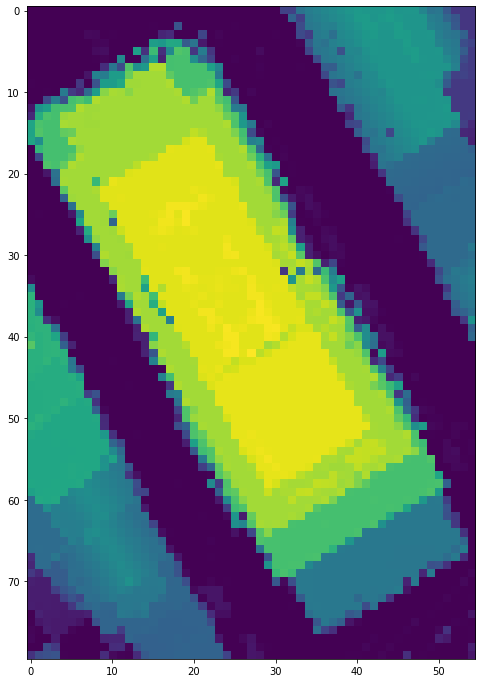

In [43]:
l = beacontifs[1][0]
b = beacontifs[1][1]
r = beacontifs[1][2]
t = beacontifs[1][3]
w = r-l
h = t-b

with rio.open(beacontifs[0][0]) as dtm: 
    with rio.open(beacontifs[0][1]) as dsm:
        terrain_array = dtm.read()
        surface_array = dsm.read()
        chm_array = np.array(surface_array - terrain_array)
        fig, ax = plt.subplots(1, figsize=(12, 12))
        crop = chm_array[0][110:190, 215:270]
        print(crop)
        show(crop, ax=ax)
        plt.show()

Looking for /media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/DHMVII_vdc_k15.shp file in: /media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15
Found.


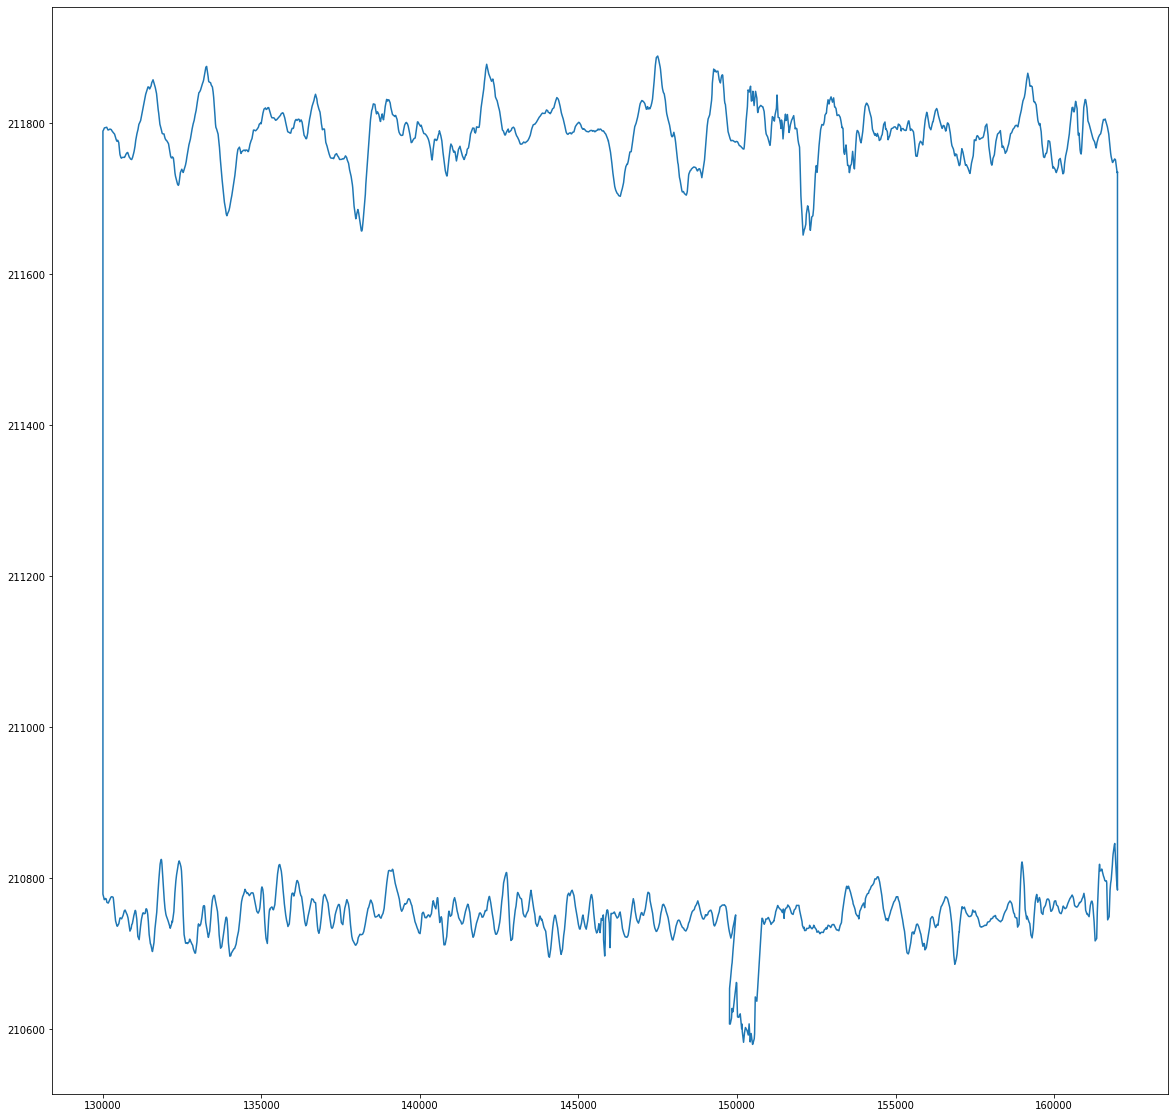

In [93]:
import zipfile
import time

def get_shape_file(tif_path, debug=False):
    geotif_folder = os.path.split(tif_path)[0]
    dsm_folder = os.path.split(geotif_folder)[0]
    k_number = dsm_folder[-3:]
    shape_name = f"DHMVII_vdc_{k_number}.shp"
    shape_path = os.path.join(dsm_folder, shape_name)
    if debug: print(f"Looking for {shape_path} file in: {dsm_folder}")
    if os.path.exists(shape_path):
        if debug: print("Found.")
        return shape_path
    else:
        if debug: print("Not found.")
        zip_path = os.path.join(dsm_folder, f"DHMVII_vdc_{k_number}.zip")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dsm_folder)
        if debug: print("Extracting zip ...")
        time.sleep(1)
        return shape_path
    
shp = get_shape_file("/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15_1_2_1_1_0.tif", True)

with fiona.open(shp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    fig, ax = plt.subplots(1, figsize=(20, 20))
    arr = np.array(shapes[5]['coordinates'][0])
    x,y = [],[]
    for i in range(len(arr)):
        x.append(arr[i][0])
        y.append(arr[i][1])
    plt.plot(x, y)
    plt.show
        

[{'coordinates': [[[153626.09338975698, 193546.87021638453], [153612.19578974694, 193549.9385043867], [153607.70471774787, 193551.19444039091], [153607.2624137476, 193548.79124038666], [153610.1859337464, 193548.14292038605], [153616.89530975372, 193546.7546323873], [153616.23015775532, 193542.92564038187], [153624.9723657593, 193540.77831238136], [153626.09338975698, 193546.87021638453]]], 'type': 'Polygon'}]


<function matplotlib.pyplot.show(*args, **kw)>

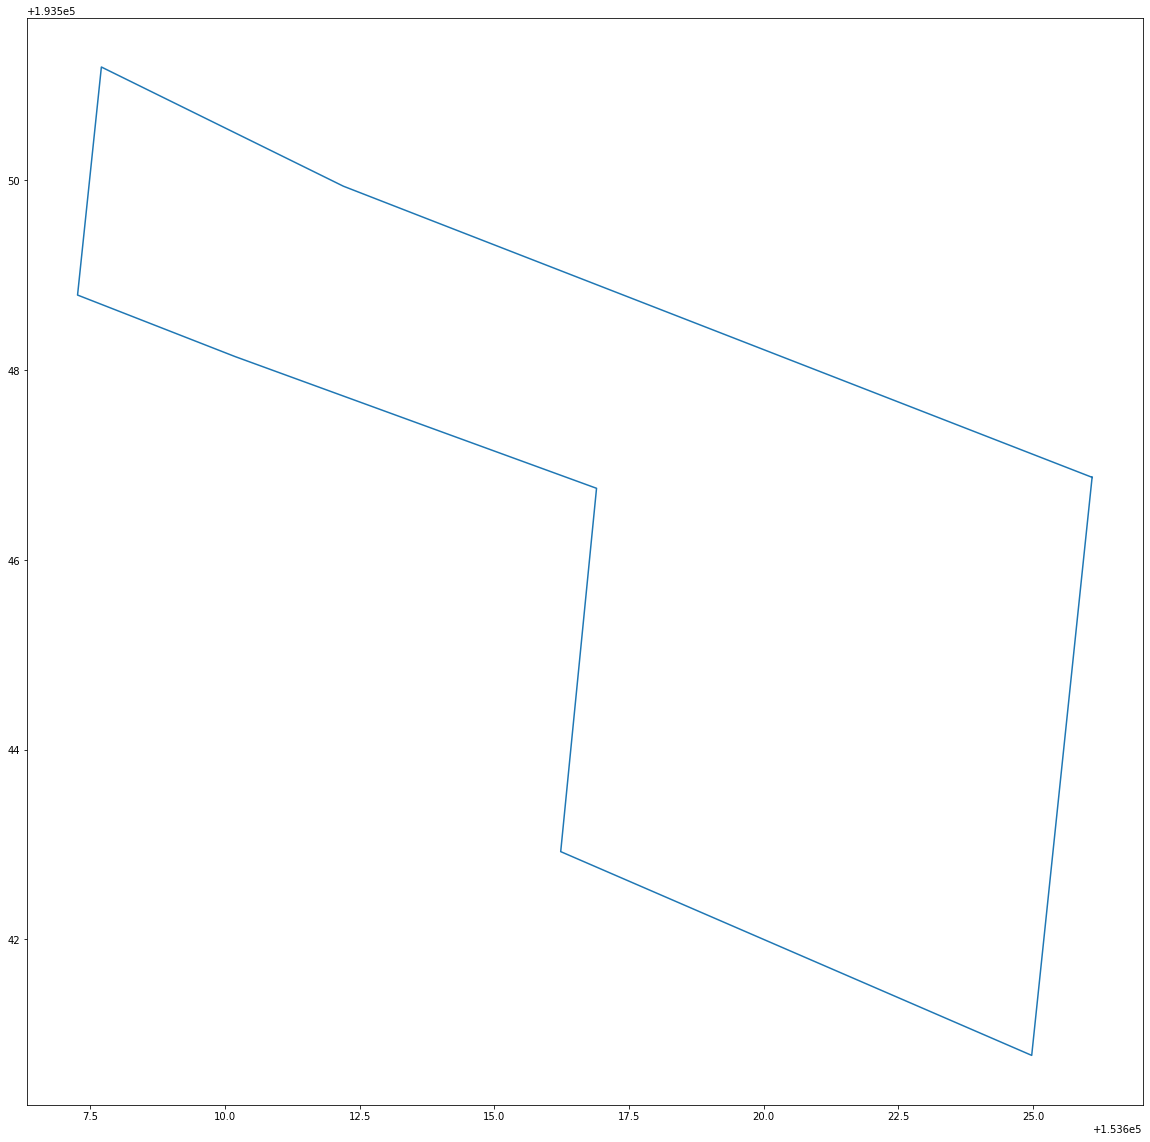

In [103]:
## Hedia's polygon API
address = "Hooiendonckstraat 49, 2801 Heffen"
address_regx = re.compile("^([A-z-]+)\s(\d+),\s(\d+)\s([A-z]+)")
result = address_regx.search(address)
street = result.group(1)
nb = result.group(2)
pc = result.group(3)
city = result.group(4)

req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/adresmatch?gemeentenaam={city}&straatnaam={street}&huisnummer={nb}&postcode={pc}").json()

objectId = req["adresMatches"][0]["adresseerbareObjecten"][0]["objectId"]

req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouweenheden/{objectId}").json()

objectId = req["gebouw"]["objectId"]

req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouwen/{objectId}").json()

polygon = [req["geometriePolygoon"]["polygon"]]

print(polygon)

loc = polygon[0]['coordinates'][0]
x,y = [],[]
for i in range(len(loc)):
    x.append(loc[i][0])
    y.append(loc[i][1])
fig, ax = plt.subplots(1, figsize=(20, 20))
plt.plot(x, y, scalex=1, scaley=1)
plt.show

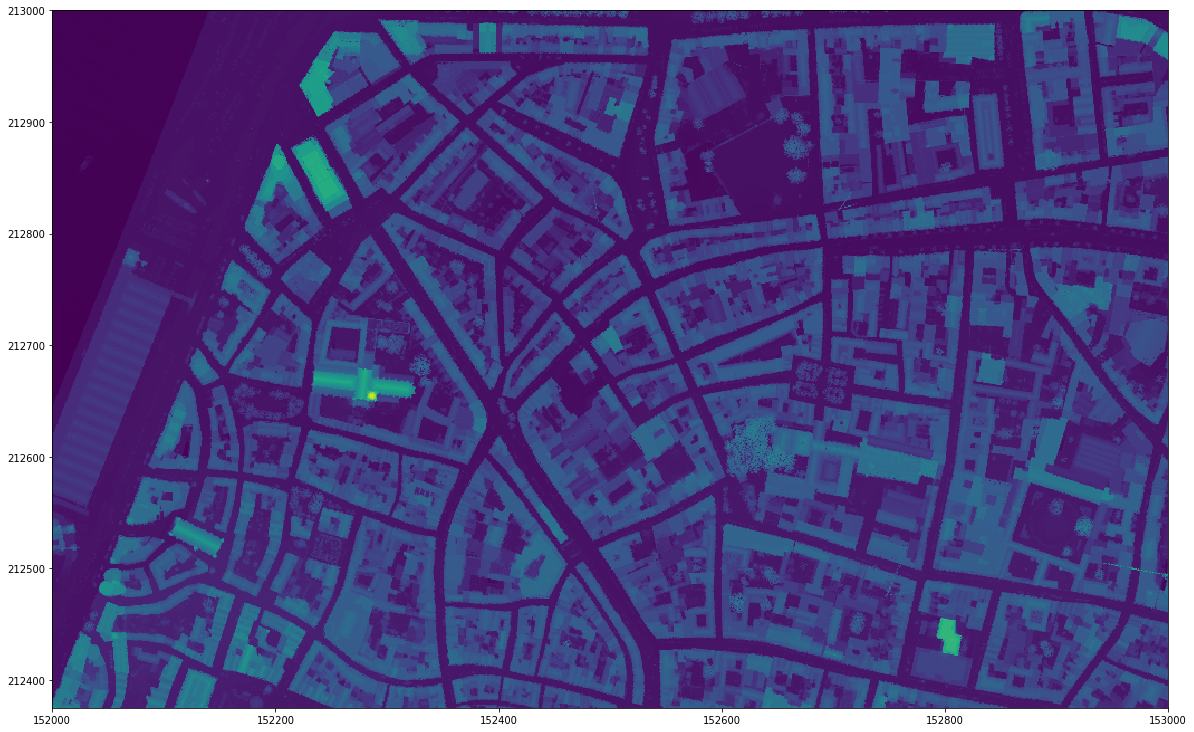

In [55]:
from rasterio import mask as riomask

tif = "/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15_1_2_1_1_0.tif"
shp = get_shape_file(tif)

fig, ax = plt.subplots(1, figsize=(20, 20))
with fiona.open(shp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    with rio.open(tif) as src:
        out_image, out_transform = riomask.mask(src, shapes, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open("masked.tif", "w", **out_meta) as dest:
            dest.write(out_image)
            
show(rio.open("masked.tif"))
plt.show()

In [ ]:
from rasterio.enums import Resampling

upscale_factor = 2

with rasterio.open("example.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )